In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import lenstronomy
print(lenstronomy.__path__)
from h0rton.configs import TrainValConfig, TestConfig
from baobab.configs import BaobabConfig
import matplotlib.pyplot as plt
import scipy.stats as stats
import h0rton.tdlmc_utils as tdlmc_utils
import baobab.sim_utils as sim_utils
from h0rton.h0_inference import h0_utils, plotting_utils
from matplotlib.ticker import AutoMinorLocator
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Plotting params
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='large')

['/home/jwp/stage/sl/lenstronomy/lenstronomy']


In [2]:
n_test = 200 # number of lenses to visualize
version_id = 3 # ID of the version folder in experiments
prec_version_id = 0 # ID of the version folder corresponding to precision ceiling
true_H0 = 70.0
true_Om0 = 0.3

version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
test_cfg_path = os.path.join(version_dir, 'mcmc_default.json')
test_cfg = TestConfig.from_file(test_cfg_path)
baobab_cfg = BaobabConfig.from_file(test_cfg.data.test_baobab_cfg_path)
train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
# Read in truth metadata
metadata = pd.read_csv(os.path.join(baobab_cfg.out_dir, 'metadata.csv'), index_col=None, nrows=n_test)
# Read in summary
summary = pd.read_csv(os.path.join(version_dir, 'summary.csv'), index_col=None, nrows=n_test)

In [3]:
# Classify 1-sigma, 2-sigma, and beyond
summary['standard_z'] = (70 - summary['H0_mean'])/summary['H0_std']
summary['class_z'] = np.digitize(np.abs(summary['standard_z'].values), [1, 2, 4])

In [4]:
samples_dir = os.path.join(version_dir, 'mcmc_default')
D_dt_dict_fnames = [f for f in os.listdir(samples_dir) if f.startswith('D_dt_dict')]
D_dt_dict_fnames.sort()
oversampling = 20

In [5]:
# Read in D_dt_samples from D_dt_dict files
H0_samples_dict = {}
kde_dict = {}
coverage_probs = {}
for i, f_name in enumerate(D_dt_dict_fnames):
    # Read in D_dt samples using lens identifier
    lens_i = int(os.path.splitext(f_name)[0].split('D_dt_dict_')[1])
    uncorrected_D_dt_samples = np.load(os.path.join(samples_dir, f_name), allow_pickle=True).item()['D_dt_samples'] # [old_n_samples,]
    # Read in redshifts and coverage sigma
    class_z, z, z_lens, z_src = summary.loc[lens_i, ['class_z', 'z', 'z_lens', 'z_src']]
    
    # Correct D_dt samples using k_ext
    uncorrected_D_dt_samples = h0_utils.remove_outliers_from_lognormal(uncorrected_D_dt_samples, 3).reshape(-1, 1) # [n_samples, 1] 
    k_ext_rv = getattr(stats, test_cfg.kappa_ext_prior.dist)(**test_cfg.kappa_ext_prior.kwargs)
    k_ext = k_ext_rv.rvs(size=[len(uncorrected_D_dt_samples), oversampling]) # [n_samples, oversampling]
    if test_cfg.kappa_ext_prior.transformed:
        D_dt_samples = (uncorrected_D_dt_samples*k_ext).flatten()
    else:
        D_dt_samples = (uncorrected_D_dt_samples/(1.0 - k_ext)).flatten() # [n_samples,]
    
    # Convert D_dt into H0
    cosmo_converter = h0_utils.CosmoConverter(z_lens, z_src, H0=true_H0, Om0=true_Om0)
    H0_samples = cosmo_converter.get_H0(D_dt_samples)
    H0_samples_dict[lens_i] = H0_samples
    
    # Get KDE approximation
    kde = stats.gaussian_kde(H0_samples)
    kde_dict[lens_i] = kde
    coverage_probs[lens_i] = kde.integrate_box_1d(low=-np.inf, high=70.0)

/home/jwp/miniconda3/envs/baobab/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [6]:
import matplotlib.cm as cm
import matplotlib

def cdf_to_scalar(cdf):
    """Convert a CDF value to a matplotlib.cm scalar
    
    Parameters
    ----------
    cdf : float
        the CDF of the individual H0 posterior evaluated at the truth,
        e.g. for 0.5 + 0.3415 if truth is exactly 1 sigma away from mean
        
    """
    return np.abs(cdf - 0.5)/0.5

In [7]:
np.geomspace(0.01, 0.99, 10)

array([0.01      , 0.01666239, 0.02776352, 0.04626065, 0.07708129,
       0.12843584, 0.21400477, 0.35658306, 0.59415253, 0.99      ])

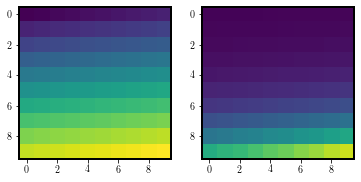

In [9]:
import matplotlib.colors as colors

################### Function to truncate color map ###################
def truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''    
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.geomspace(minval, maxval, n)))

    arr = np.linspace(0, 50, 100).reshape((10, 10))
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(arr, interpolation='nearest', cmap=cmapIn)
    ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
    plt.show()

    return new_cmap

viridis_mod = truncate_colormap(cmapIn='viridis', minval=.01, maxval=.925)  # calls function to truncate colormap


69.73989973163273 69.29914941392879 70.28412789418647
[0.8413 0.9773 0.9986]
[0.6826 0.9546 0.9972]


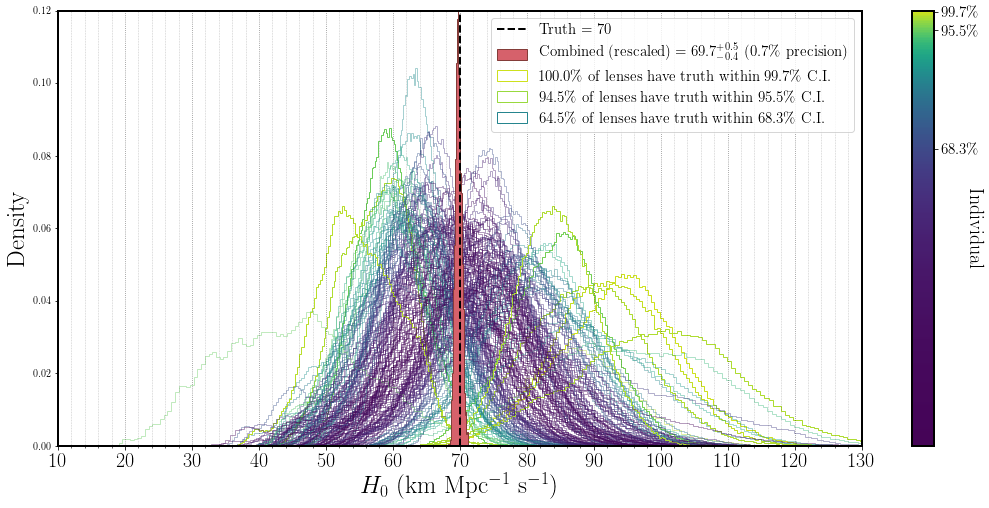

In [22]:
plt.close('all')

# CDF change from 0.5 at 1, 2, 3 sigmas away from mean,
# for a standard normal dist
standard_normal_p = np.array([0.3413, 0.4773, 0.4986])
cmap = viridis_mod#cm.viridis

fig, ax = plt.subplots(figsize=(18, 8))
# Tune alpha based on standard z score
class_z_to_alpha = {0: 0.4, 1: 0.4, 2: 1.0, 3: 1.0}
#H0_grid = np.linspace(10, 130, 400)
for i, lens_i in enumerate(H0_samples_dict):
    class_z, z_lens, z_src = summary.loc[lens_i, ['class_z', 'z_lens', 'z_src']]
    cbar_scalar = cdf_to_scalar(coverage_probs[lens_i])
    # Plot individual H0 posterior
    H0_samples = H0_samples_dict[lens_i]
    H0_grid = np.histogram_bin_edges(H0_samples, bins='scott')
    #if np.abs(H0_grid[0] - 20.0) > 5:
    #    H0_grid = 50
    ax.hist(H0_samples, bins=H0_grid, histtype='step', alpha=class_z_to_alpha[class_z], density=True, color=cmap(cbar_scalar))#color_map_color(cbar_scalar))
# Plot combined H0 posterior
h0_samples = np.load(os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id), 'combined_H0_summary_kde.npy'))
combined_bin = np.histogram_bin_edges(h0_samples, bins='scott')
combined_center, combined_lower_sig, combined_upper_sig = tuple(np.quantile(h0_samples, [0.5, 0.16, 0.84]))
print(combined_center, combined_lower_sig, combined_upper_sig)

ax.hist(h0_samples, bins=combined_bin, color='#d6616b', edgecolor='#843c39', histtype='stepfilled', density=False, weights=np.ones_like(h0_samples)/3100.0, linewidth=1)
# Plot truth
plt.axvline(70, color='k', lw=2, linestyle='--')

# Plot colorbar for individual H0 posterior
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
tick_cdf = standard_normal_p + 0.5 # CDF at mean + 1, 2, 3 std
cbar_ticks = cdf_to_scalar(tick_cdf)
print(tick_cdf)
print(cbar_ticks)
cbar_ticklabels = [r'{:0.1f}\%'.format((c - 0.5)*2.0*100) for c in tick_cdf]
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), orientation='vertical', ticks=cbar_ticks)
#cbar.set_clim([0.0, 0.7])
#cb.ax.plot([0, 1], [rms]*2, 'w') 
plt.xlim([10, 130])
plt.ylim([0.0, 0.12])
cbar.set_label("Individual", rotation=270, fontsize=20)
cbar.ax.set_yticklabels(cbar_ticklabels, fontsize=15)

legend_elements = [
                   Line2D([0], [0], color='k', lw=2, alpha=1, linestyle='--', label='Truth = 70'),
                Patch(facecolor='#d6616b', edgecolor='#843c39', lw=1, label='Combined (rescaled) = $69.7^{+0.5}_{-0.4}$ (0.7\% precision)'),
    Patch(facecolor='white', edgecolor=cmap(standard_normal_p[2] + 0.5), label=r'100.0\% of lenses have truth within 99.7\% C.I.'),
    Patch(facecolor='white', edgecolor=cmap(standard_normal_p[1] + 0.5), label=r'94.5\% of lenses have truth within 95.5\% C.I.'),
    Patch(facecolor='white', edgecolor=cmap(standard_normal_p[0] + 0.5), label=r'64.5\% of lenses have truth within 68.3\% C.I.'),
    #Line2D([0], [0], color=cmap(standard_normal_p[2] + 0.5), lw=1, alpha=1, label=r'100\% of lenses have truth within 99.7\% C.I.'),
     #Line2D([0], [0], color=cmap(standard_normal_p[1] + 0.5), lw=1, alpha=1, label=r'94.5\% of lenses have truth within 95.5\% C.I.'),
    #Line2D([0], [0], color=cmap(standard_normal_p[0] + 0.5), lw=1, alpha=1, label=r'64.5\% of lenses have truth within 68.3\% C.I.'),
               ]
ax.legend(handles=legend_elements, fontsize=15)

plt.xlabel("$H_0$ (km Mpc$^{-1}$ s$^{-1}$)", fontsize=25)
plt.ylabel("Density", fontsize=25)
plt.xticks(np.arange(10, 130 + 1, 10), fontsize=20)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis="x", color="black", alpha=.5,  linestyle='dotted')
ax.grid(axis="x", color="black", which='minor', alpha=.2,  linestyle=(0, (1, 1)))
#plt.tight_layout()
plt.show()

In [23]:
fig.savefig('../overlaid_200_posteriors.png', dpi=100, bbox_inches='tight', pad_inches=0.1)

In [54]:
cmap(standard_normal_p[0] + 0.5)

(0.1436258235294118, 0.5221231176470587, 0.556225, 1.0)

In [55]:
cdf_values = np.array(list(coverage_probs.values()))
cdf_values_binned = np.digitize(np.abs(cdf_values - 0.5), list(standard_normal_p) + [0.5])

[0.645 0.    0.    0.    0.    0.3   0.    0.    0.    0.055]
[129.   0.   0.   0.   0.  60.   0.   0.   0.  11.]
1.0


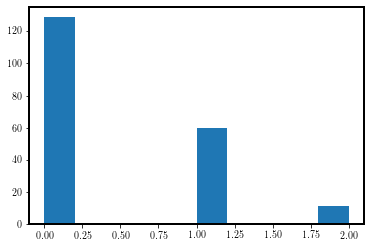

In [56]:
counts, _, _ = plt.hist(cdf_values_binned)
print(counts/200)
print(counts)
print((counts[0] + counts[-1] + 60)/200.0)

In [195]:
np.digitize(np.abs(1 - 0.5), list(standard_normal_p) + [0.5])

4

In [191]:
0.3413, 0.3413 + 0.1359, 0.3413 + 0.1359 + 0.0214, 0.5

(0.3413, 0.47719999999999996, 0.49859999999999993, 0.5)

In [17]:
0.65+0.305+0.035 + 0.01

1.0

In [15]:
0.645 + 0.3, 0.645 + 0.3 + 0.055

(0.9450000000000001, 1.0)